In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
import itertools as it
from imageio import imwrite

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.nn.parameter as P
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets

# Data preparation

In [2]:
img_path = "/home/md359230/DeepLearning/assignment2/data/cityscapes/*.png"
print(len(glob.glob(img_path)))

3475


In [3]:
base_path = "/home/md359230/DeepLearning/assignment2/data/cityscapes"
images = [file for file in os.listdir(base_path) if file.endswith(".png")]

In [4]:
np.random.shuffle(images)
train_images, test_images = images[:-500], images[-500:]

In [6]:
print(len(train_images), len(test_images))

2975 500


In [7]:
check_array = np.array(
    [[116, 17, 36],
     [152, 43,150],
     [106,141, 34],
     [ 69, 69, 69],
     [  2,  1,  3],
     [127, 63,126],
     [222, 52,211],
     [  2,  1,140],
     [ 93,117,119],
     [180,228,182],
     [213,202, 43],
     [ 79,  2, 80],
     [188,151,155],
     [  9,  5, 91],
     [106, 75, 13],
     [215, 20, 53],
     [110,134, 62],
     [  8, 68, 98],
     [244,171,170],
     [171, 43, 74],
     [104, 96,155],
     [ 72,130,177],
     [242, 35,231],
     [147,149,149],
     [ 35, 25, 34],
     [155,247,151],
     [ 85, 68, 99],
     [ 71, 81, 43],
     [195, 64,182],
     [146,133, 92]])

In [8]:
# Encoding in form of 1e6 * x + 1e3 * y + z -> id
label_encoding = {}
def encodeLabel(label):
    return label[0] * 1000000 + label[1] * 1000 + label[2]

for label_code, label in enumerate(check_array):
    label_encoding[encodeLabel(label)] = label_code

In [9]:
def process_images(images, base_path, target_path):
    counter = 0
    for image in images:
        counter += 1
        if counter % 100 == 0:
            print(counter)
        # Split image into raw image and class annotation
        data = plt.imread(os.path.join(base_path, image)) * 255
        raw_image, label = data[:, :256, :], data[:, 256:, :]

        raw_image = raw_image.astype('uint8')
        # Save class annotation as txt
        label = np.array([label_encoding[encodeLabel(label[x, y])] 
                          for x, y in it.product(range(256), range(256))])
        label = label.reshape(256, 256).astype('uint8')

        # Save training image and class annotation
        imwrite(os.path.join(target_path, image), raw_image)
        np.savetxt(os.path.join(target_path, image[:-4] + ".txt"), label, fmt="%d")

In [10]:
train_path = "/home/md359230/DeepLearning/assignment2/data/train"
process_images(train_images, base_path, train_path)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [11]:
test_path  = "/home/md359230/DeepLearning/assignment2/data/test"
process_images(test_images, base_path, test_path)

100
200
300
400
500


In [12]:
! ls /home/md359230/DeepLearning/assignment2/data/train | wc -l

5950


In [13]:
! ls /home/md359230/DeepLearning/assignment2/data/test | wc -l

1000


# Data loading

In [44]:
class CityScapesDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        data = plt.imread(img_name) * 255
        image, label = data[:, :256, :], data[:, 256:, :]
        sample = {'image': image, 'label': label}
        
        return sample

In [45]:
dataset_path = '/home/md359230/DeepLearning/assignment2/data/cityscapes'

In [46]:
csds = CityScapesDataSet(dataset_path)

In [47]:
print(type(csds[0]))

<class 'dict'>


In [48]:
print(len(csds))

3475


In [49]:
dataloader = DataLoader(csds,
                        batch_size=1,
                        shuffle=True,
                        num_workers=4)

In [53]:
for i, batch in enumerate(dataloader):
    print(batch)
    if i > 0:
        break

{'label': tensor([[[[  2.,   1.,   3.],
          [  2.,   1.,   3.],
          [  2.,   1.,   3.],
          ...,
          [  2.,   1.,   3.],
          [  2.,   1.,   3.],
          [  2.,   1.,   3.]],

         [[ 35.,  25.,  34.],
          [ 93., 117., 119.],
          [ 93., 117., 119.],
          ...,
          [ 35.,  25.,  34.],
          [ 69.,  69.,  69.],
          [ 35.,  25.,  34.]],

         [[ 35.,  25.,  34.],
          [147., 149., 149.],
          [147., 149., 149.],
          ...,
          [ 69.,  69.,  69.],
          [ 69.,  69.,  69.],
          [ 35.,  25.,  34.]],

         ...,

         [[ 79.,   2.,  80.],
          [195.,  64., 182.],
          [195.,  64., 182.],
          ...,
          [127.,  63., 126.],
          [127.,  63., 126.],
          [ 79.,   2.,  80.]],

         [[ 35.,  25.,  34.],
          [127.,  63., 126.],
          [127.,  63., 126.],
          ...,
          [ 69.,  69.,  69.],
          [ 85.,  68.,  99.],
          [ 35.,  25.,

# Unit testing

In [81]:
np.loadtxt(os.path.join(train_path, '367.txt'), dtype='int')

array([[ 4, 24,  4, ...,  4,  4,  4],
       [ 4,  3, 24, ..., 27, 27, 24],
       [24,  3,  3, ..., 16, 16, 24],
       ...,
       [24, 26, 26, ...,  6, 28,  1],
       [24,  3,  3, ...,  1,  5, 11],
       [ 4, 24,  4, ..., 24, 11, 24]])

In [82]:
np.allclose(np.loadtxt(os.path.join(train_path, '367.txt'), dtype='int'), label)

True

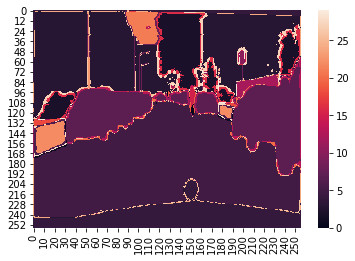

In [20]:
test = np.loadtxt(os.path.join(train_path, '0002.txt'), dtype='int')
import seaborn as sns
sns.heatmap(test)

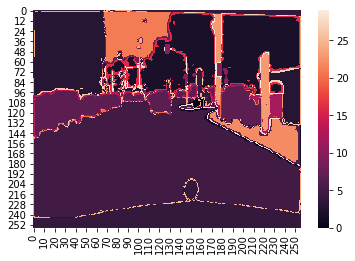

In [21]:
test = np.loadtxt(os.path.join(test_path, '0007.txt'), dtype='int')
import seaborn as sns
sns.heatmap(test)